In [1]:
from src.data_loader import DataLoader
from src.sales_processor import SalesProcessor
from src.feature_engineer import FeatureEngineer
from src.data_aggregator import DataAggregator
import pandas as pd


In [2]:
data_loader = DataLoader()
# data_dict = data_loader.load_all_data()
customer_master = data_loader.load_customer_master()
sales_data = data_loader.load_sales_data()

sales_processor = SalesProcessor(sales_data, customer_master)
sales_results = sales_processor.process_sales_data()

last_billed = sales_results['last_billed']
sales_journey = sales_results['sales_journey']
days_between_purchase = sales_results['days_between_purchase']


print(f"✅ Sales data processed successfully:")
print(f"   - Last Billed: {last_billed.shape}")
print(f"   - Sales Journey: {sales_journey.shape}")
print(f"   - Days Between Purchase: {days_between_purchase.shape}")


        

⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `tableau_delta_tables`
⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `sap_data`
⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `jkc`
⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `gold_layer`
📖 Reading table: `customer_master`...
✅ Successfully read data from `customer_master`.
📖 Reading table: `sales_data`...
✅ Successfully read data from `sales_data`.


/Users/sanyamjain/Desktop/work/dealer-churn-1/.venv/lib/python3.11/site-packages/pyspark/sql/connect/client/reattach.py:253: UserWarning: ReleaseExecute failed with exception: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.INTERNAL
	details = "[INVALID_HANDLE.SESSION_NOT_FOUND] The handle d0e1b1ae-9ebb-4cc8-a036-4ef0e4cde386 is invalid. Session not found. SQLSTATE: HY000"
	debug_error_string = "UNKNOWN:Error received from peer  {grpc_message:"[INVALID_HANDLE.SESSION_NOT_FOUND] The handle d0e1b1ae-9ebb-4cc8-a036-4ef0e4cde386 is invalid. Session not found. SQLSTATE: HY000", grpc_status:13}"
>.
  warnings.warn(f"ReleaseExecute failed with exception: {e}.")


PySparkRuntimeError: [RESPONSE_ALREADY_RECEIVED] OPERATION_NOT_FOUND on the server but responses were already received from it.

In [ ]:
print("\n🔧 Step 3: Feature Engineering")
print("-" * 30)
feature_engineer = FeatureEngineer(sales_journey, customer_master, sales_processor.reference_date)

# Add dealership age
customer_master = feature_engineer.add_dealership_age()

# Create monthly sales features
monthly_sales = feature_engineer.create_monthly_sales_features()

# Create territory and club features
terrwise_monthly_sales, dealerclubwise_monthly_sales = feature_engineer.create_territory_and_club_features(monthly_sales)

# Merge territory and club features
monthly_sales = pd.merge(
    monthly_sales, 
    terrwise_monthly_sales, 
    on=['territory_code', 'period'], 
    how='left'
).merge(
    dealerclubwise_monthly_sales, 
    on=['dealer_club_category', 'period'], 
    how='left'
)


🔧 Step 3: Feature Engineering
------------------------------


In [ ]:
sas_monthly_data = data_loader.load_sas_monthly_data()
# Process SAS data
sas_monthly_data = feature_engineer.process_sas_data(sas_monthly_data)

# Create rotation features
monthly_sales, terrwise_sas, dealerclub_wise_sas = feature_engineer.create_rotation_features(
    monthly_sales, sas_monthly_data
)

# Merge SAS features
monthly_sales = pd.merge(
    monthly_sales, 
    terrwise_sas, 
    on=['territory_code', 'period'], 
    how='left'
).merge(
    dealerclub_wise_sas, 
    on=['dealer_club_category', 'period'], 
    how='left'
)

📖 Reading table: `monthly_club_mapping`...
✅ Successfully read data from `monthly_club_mapping`.


In [ ]:
credit_note_df = data_loader.load_credit_note_data()

📖 Reading table: `credit_note`...
✅ Successfully read data from `credit_note`.


In [ ]:
movement_counts = feature_engineer.create_club_movement_features(sas_monthly_data)

outstanding_df = data_loader.load_outstanding_data()


📖 Reading table: `customer_financial`...
✅ Successfully read data from `customer_financial`.


In [ ]:
# Process outstanding data
outstanding_df = feature_engineer.process_outstanding_data(outstanding_df)
# Create credit note features
monthly_credit_note = feature_engineer.create_credit_note_features(credit_note_df)


In [ ]:
orders_df = data_loader.load_orders_data()

📖 Reading table: `orders`...
✅ Successfully read data from `orders`.


In [ ]:
claims_data = data_loader.load_claims_data()

📖 Reading table: `claims_data`...
✅ Successfully read data from `claims_data`.


In [ ]:
visits_data = data_loader.load_visits_data()

📖 Reading table: `visits_flat`...
✅ Successfully read data from `visits_flat`.


In [ ]:

# Create order type features
order_types = feature_engineer.create_order_type_features(sales_data, orders_df)

# Create claims features
claim_count = feature_engineer.create_claims_features(claims_data)

# Create visit features
visit_count = feature_engineer.create_visit_features(visits_data)

# Create CM labels
monthly_sales = feature_engineer.create_cm_labels(monthly_sales)

print(f"✅ Features engineered successfully:")
print(f"   - Monthly Sales Features: {monthly_sales.shape}")
print(f"   - Movement Counts: {movement_counts.shape}")
print(f"   - Outstanding Data: {outstanding_df.shape}")
print(f"   - Credit Note Features: {monthly_credit_note.shape}")
print(f"   - Order Type Features: {order_types.shape}")
print(f"   - Claims Features: {claim_count.shape}")
print(f"   - Visit Features: {visit_count.shape}")


✅ Features engineered successfully:
   - Monthly Sales Features: (79558, 21)
   - Movement Counts: (9093, 4)
   - Outstanding Data: (308912, 9)
   - Credit Note Features: (229076, 4)
   - Order Type Features: (248355, 5)
   - Claims Features: (163493, 5)
   - Visit Features: (116209, 3)


/Users/sanyamjain/Desktop/work/dealer-churn-1/src/feature_engineer.py:276: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_data = monthly_data.groupby('dealer_code', group_keys=False).apply(assign_cm_labels)


In [ ]:

# Step 4: Data Aggregation
print("\n📈 Step 4: Data Aggregation")
print("-" * 30)

territory_master = data_loader.load_territory_master()

data_aggregator = DataAggregator()

final_data = data_aggregator.aggregate_all_data(
    monthly_sales, outstanding_df, monthly_credit_note, order_types, 
    claim_count, visit_count, days_between_purchase, movement_counts, 
    customer_master, territory_master, last_billed, save_dataset=True
)

print("\n🎉 Pipeline completed successfully!")
print(f"Final dataset shape: {final_data.shape}")
print(f"Output saved to: offset_features.csv")



📈 Step 4: Data Aggregation
------------------------------
📖 Reading table: `territory_master`...
❌ Error reading table `territory_master`: (org.apache.spark.SparkSQLException) [INVALID_HANDLE.SESSION_CHANGED] The handle d0e1b1ae-9ebb-4cc8-a036-4ef0e4cde386 is invalid. The existing Spark server driver instance has restarted. Please reconnect. SQLSTATE: HY000


SparkConnectGrpcException: (org.apache.spark.SparkSQLException) [INVALID_HANDLE.SESSION_CHANGED] The handle d0e1b1ae-9ebb-4cc8-a036-4ef0e4cde386 is invalid. The existing Spark server driver instance has restarted. Please reconnect. SQLSTATE: HY000

In [1]:
from src.model_pipeline import ModelPipeline


model_pipeline = ModelPipeline()

/Users/sanyamjain/Desktop/work/dealer-churn-1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Starting Complete Training Pipeline

Data Preprocessing [██████------------------------] 20.0% (1/5)
   Preparing and encoding data
🚀 Starting data preprocessing pipeline...
⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `data_science`
📊 Loading data from DLT table: offset_features...
📖 Reading table: `offset_features`...
✅ Successfully read data from `offset_features`.
⚠️  Warning: No dtype file found for DLT table offset_features
   This may cause XGBoost compatibility issues if data types are not numeric
✅ Data loaded successfully. Shape: (7714, 396)
📊 Data types summary:
   - Object columns: 6
   - Numeric columns: 390
🔍 Filtering data for recent churners...
✅ Filtered data. Original: (7714, 396), Filtered: (6159, 396)
📈 Creating severity feature...
✅ Severity feature created
🏆 Encoding dealer club categories...
✅ Dealer club categories encoded
🌍 Encoding zone features...
✅ Zone 

/Users/sanyamjain/Desktop/work/dealer-churn-1/src/data_preprocessor.py:149: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[self.target_column] = df[self.target_column].replace(target_encoding)


✅ Randomized search completed!
   Best params: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
   Best score: 0.9084

Grid Search [████████████████████----------] 66.7% (2/3)
   Refining parameters
🔍 Performing grid search...
🔄 Starting grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
✅ Grid search completed!
   Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 1.0}
   Best score: 0.9093

Final Training [██████████████████████████████] 100.0% (3/3)
   Training with best parameters
🎯 Training final model...
⚖️  Calculating class weights...
✅ Class distribution: {0: 4470, 1: 457}
✅ Scale pos weight: 9.7812
✅ Final model trained successfully!
💾 Saving model to models/xgb_churn_model.pkl...
✅ Model saved successfully!
📊 Extracting feature importance...
✅ Feature importance extracted
💾 Saving feature importance to

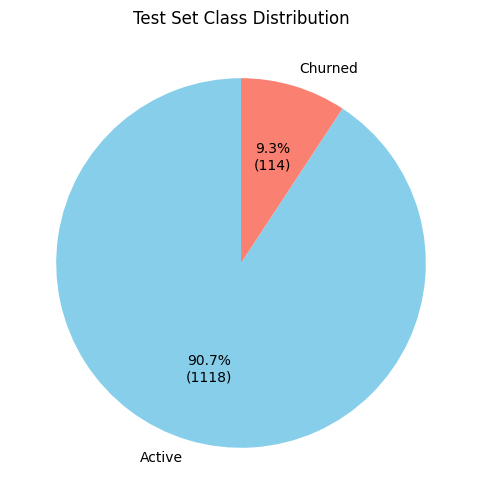

✅ Class distribution plotted
📊 Plotting confusion matrix...


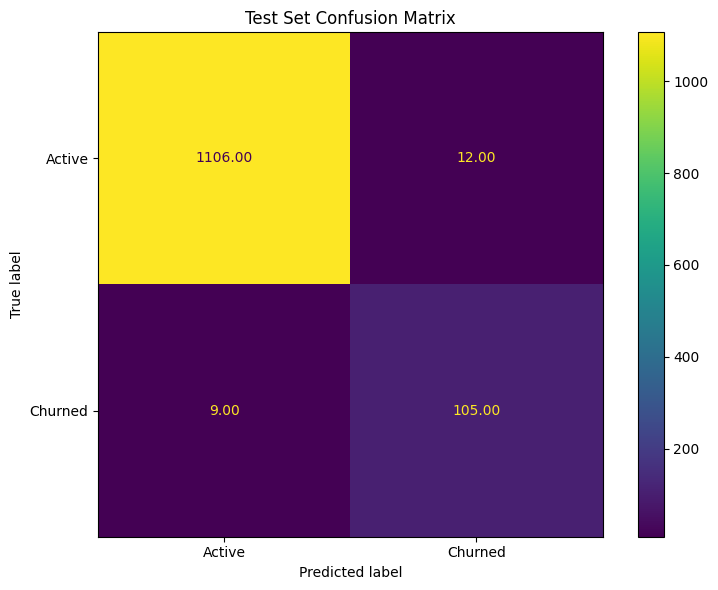

✅ Confusion matrix plotted
📊 Plotting ROC curve...


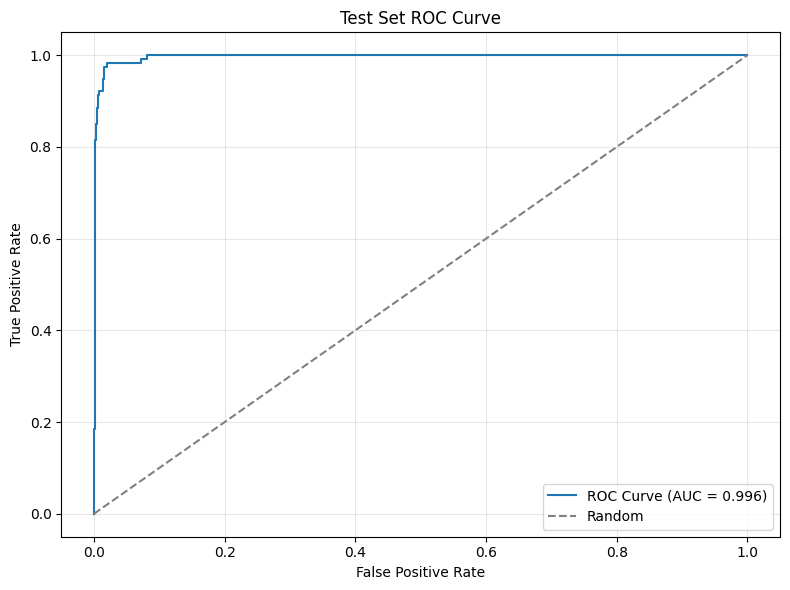

✅ ROC curve plotted
💾 Saving evaluation results to output/evaluation_results.csv...
✅ Evaluation results saved!

🎉 Model evaluation completed successfully!

Model Explanation [████████████████████████------] 80.0% (4/5)
   Generating SHAP explanations
🚀 Starting comprehensive model explanation...
🔍 Creating SHAP explainer...
✅ SHAP explainer created successfully!
🧮 Calculating SHAP values for 1232 samples...
✅ SHAP values calculated successfully!
📋 Creating explanations DataFrame...


1232it [00:00, 2592.77it/s]


✅ Explanations DataFrame created
💾 Saving explanations to output/shap_explanations.csv...
✅ Explanations saved successfully!

📊 Generating explanation plots...
📊 Plotting global feature importance (top 20)...


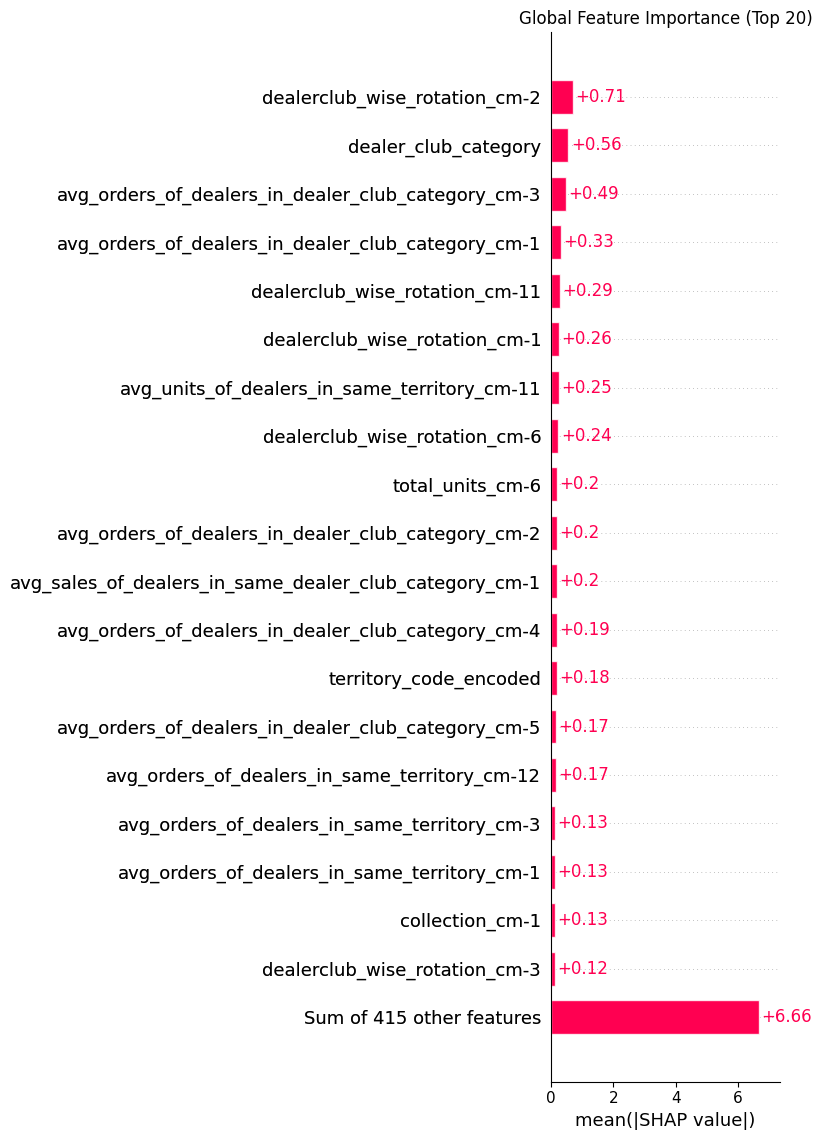

✅ Global importance plot created
📊 Plotting SHAP summary plot (top 20)...


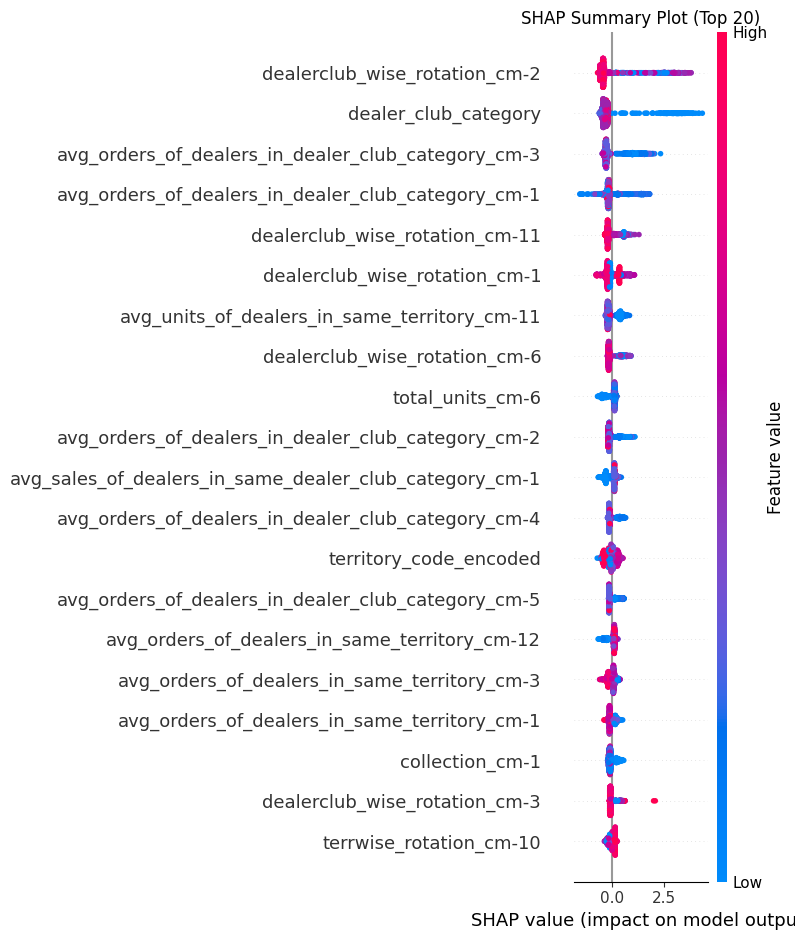

✅ Summary plot created
🔍 Explaining individual prediction for index 0...


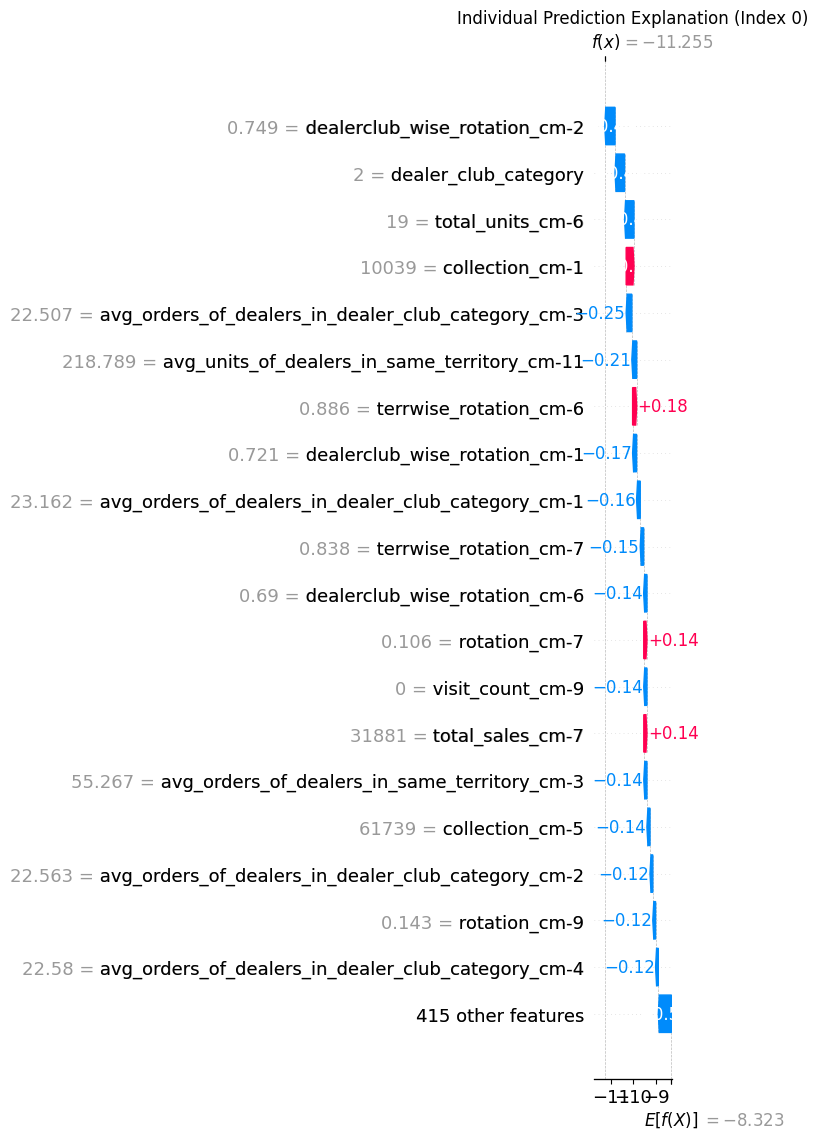

✅ Individual explanation created
🔍 Explaining individual prediction for index 1...


/Users/sanyamjain/Desktop/work/dealer-churn-1/src/model_explainer.py:134: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


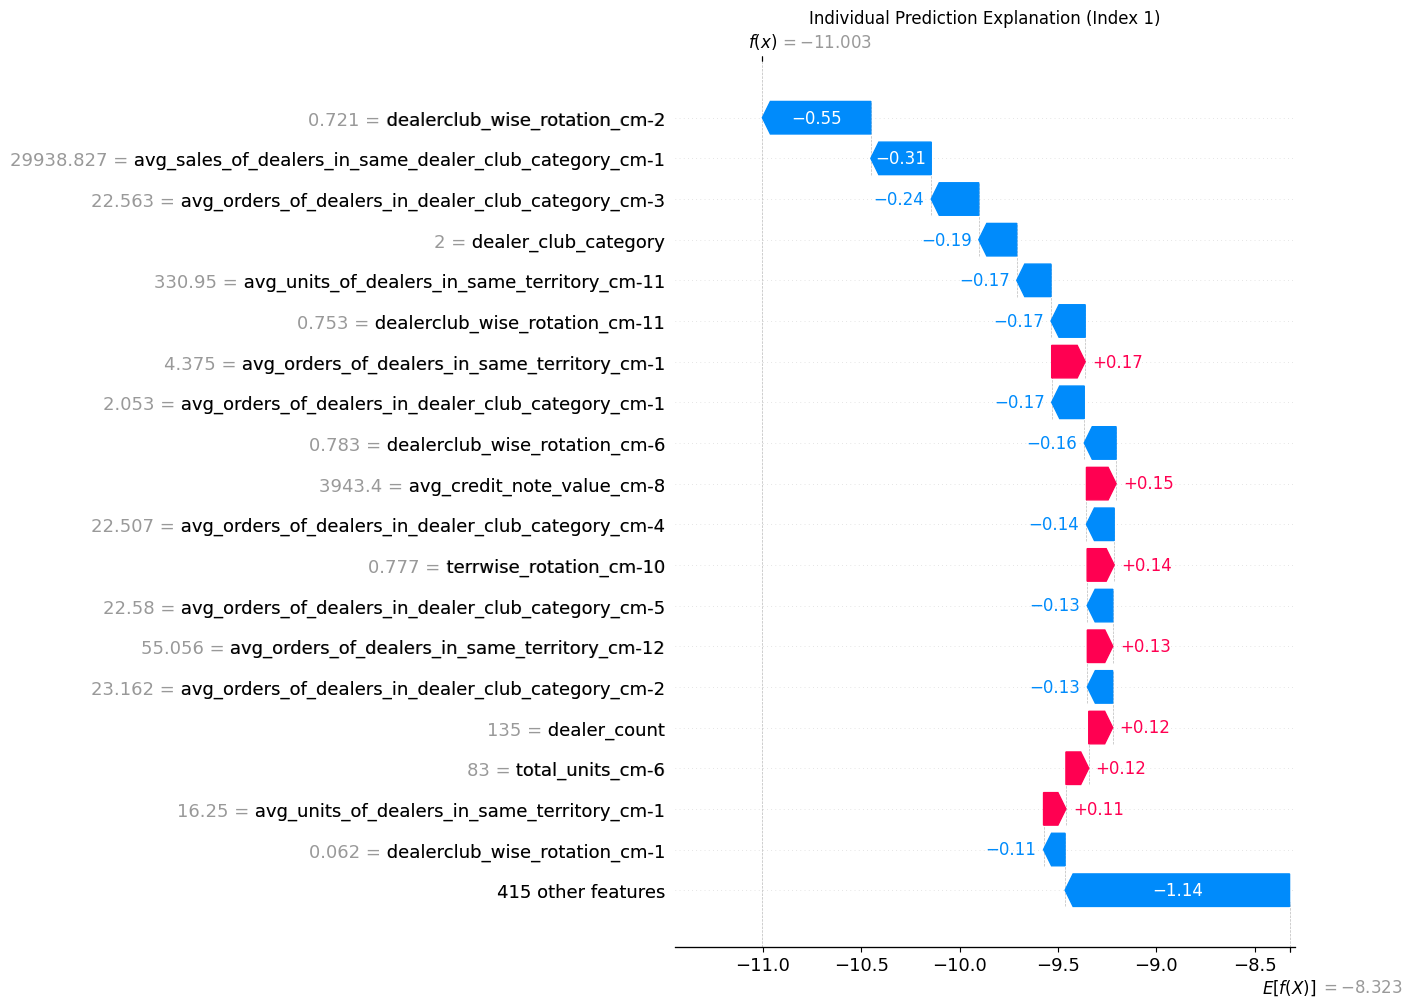

✅ Individual explanation created
🔍 Explaining individual prediction for index 2...


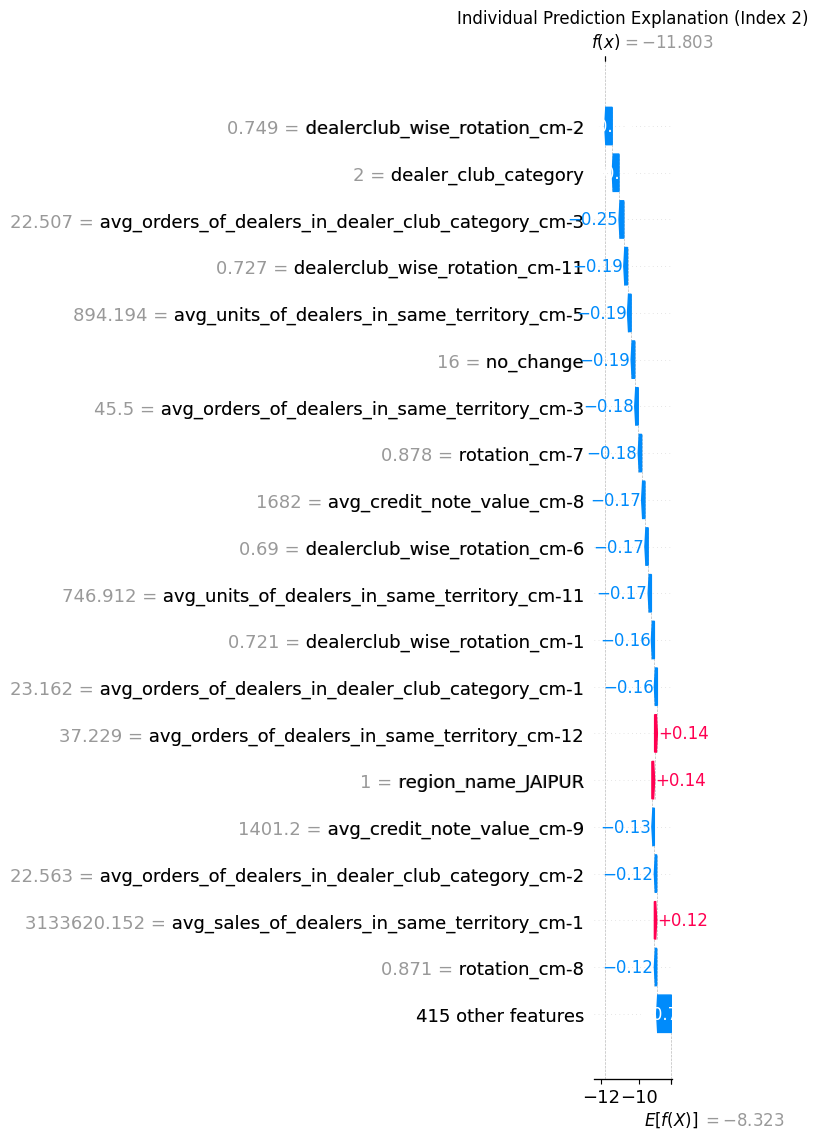

✅ Individual explanation created
🔍 Analyzing top 10 churn drivers...
✅ Top 10 churn drivers identified

🎉 Model explanation completed successfully!

Pipeline Setup [██████████████████████████████] 100.0% (5/5)
   Setting up production predictor
💾 Saving model to models/xgb_churn_model.pkl...
💾 Saving preprocessor info to models/xgb_churn_model_preprocessor_info.pkl...
✅ Preprocessor info saved!
✅ Model saved successfully!
📂 Loading model from models/xgb_churn_model.pkl...
✅ Model loaded successfully!
✅ Preprocessor info loaded from file
✅ Preprocessor info loaded

🎉 Complete training pipeline finished successfully!
Model saved to: models/xgb_churn_model.pkl
Feature importance saved to: models/feature_importance.csv


In [ ]:
results = model_pipeline.run_complete_training_pipeline(data_path="offset_features")

In [2]:
prediction_results = model_pipeline.run_production_prediction_pipeline(data_path="offset_features")

🚀 Starting Production Prediction Pipeline
📂 Loading model from models/xgb_churn_model.pkl...
✅ Model loaded successfully!
✅ Preprocessor info loaded from file
🚀 Starting prediction for all dealers...
📊 Loading data from offset_features...
⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `data_science`
📊 Loading data from DLT table: offset_features...
📖 Reading table: `offset_features`...
✅ Successfully read data from `offset_features`.
🔍 Found dtype file: offset_features_dtypes.json
✅ Data types loaded from: offset_features_dtypes.json
   Columns: 397
   Shape: [7714, 397]
✅ Data types restored for 397 columns
✅ Data types restored from offset_features_dtypes.json
✅ Data loaded successfully. Shape: (7714, 396)
📊 Data types summary:
   - Object columns: 6
   - Numeric columns: 390
🔧 Preparing data for production prediction...
📊 Applying preprocessing steps...
✅ Data prepared. Shape: (6159

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:dealer_count: object

In [ ]:
from dlt_utils import DLTWriter

dlt_writer = DLTWriter(catalog="provisioned-tableau-data", schema="data_science")
file_path = "dealer_churn_predictions"
dlt_writer.write_table(prediction_results, file_path, mode="overwrite")


In [ ]:
# import pandas as pd
# pd.set_option('display.max_columns', None)

In [ ]:
# df_prod = pd.read_csv('offset_features.csv')
# df_ref = pd.read_csv('_offset_features.csv')
